# Q1

## Install Required Libraries

In [ ]:
!pip install --quiet gensim tqdm nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Load and Explore the IMDb Dataset

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/IMDB Dataset.csv')

# Show basic info
print("Shape of the dataset:", df.shape)
print("\nSample rows:")
print(df.head())


Shape of the dataset: (50000, 2)

Sample rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


## Preprocess the Text

In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import pandas as pd

tqdm.pandas()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove HTML
    text = re.sub(r'<.*?>', '', text)
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Basic whitespace tokenization (instead of NLTK word_tokenize)
    tokens = text.split()
    # Remove stopwords and lemmatize
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(cleaned)



In [ ]:
df['cleaned_review'] = df['review'].progress_apply(preprocess_text)


100%|██████████| 50000/50000 [00:35<00:00, 1422.90it/s]


## Train Word2Vec on Tokenized Training Data

In [ ]:
from sklearn.model_selection import train_test_split

# Ensure labels are created
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Train/Val/Test split using cleaned_review
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['cleaned_review'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)


In [ ]:
train_tokens = [text.split() for text in train_texts]


In [ ]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=train_tokens,
    vector_size=300,
    window=5,
    min_count=2,
    workers=4,
    sg=1
)


## Prepare Tokenizer, Padded Sequences & Embedding Matrix


Tokenize text

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize and fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(train_texts)
X_val_seq = tokenizer.texts_to_sequences(val_texts)
X_test_seq = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to the same length
maxlen = 200
X_train = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_val = pad_sequences(X_val_seq, maxlen=maxlen, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')


Prepare embedding matrix from Word2Vec

In [ ]:
import numpy as np

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


## Build and Train RNN, LSTM, GRU, BiLSTM Models


Common Imports + Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)


Define a Reusable Model Builder

In [ ]:
def build_model(model_type='lstm'):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=maxlen,
                        trainable=False))

    if model_type == 'rnn':
        model.add(SimpleRNN(128, return_sequences=False))
    elif model_type == 'lstm':
        model.add(LSTM(128, return_sequences=False))
    elif model_type == 'gru':
        model.add(GRU(128, return_sequences=False))
    elif model_type == 'bilstm':
        model.add(Bidirectional(LSTM(128, return_sequences=False)))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


Train All Models

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = {}

for model_name in ['rnn', 'lstm', 'gru', 'bilstm']:
    print(f"\n🔁 Training {model_name.upper()} model...")

    model = build_model(model_type=model_name)
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=1
    )

    # Predict on test set
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Save all metrics
    results[model_name] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    }



🔁 Training RNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.5042 - loss: 0.7297 - val_accuracy: 0.5224 - val_loss: 0.6919
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5117 - loss: 0.6981 - val_accuracy: 0.5128 - val_loss: 0.6882
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5246 - loss: 0.6880 - val_accuracy: 0.5032 - val_loss: 0.6945
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5185 - loss: 0.6935 - val_accuracy: 0.6954 - val_loss: 0.5900
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6110 - loss: 0.6475 - val_accuracy: 0.5230 - val_loss: 0.6918
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.5142 - loss: 0.6937 - val_accuracy: 0.5182 - val_loss: 0.6874
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.5352 - loss: 0.6862 - val_accuracy: 0.5154 - val_loss: 0.6875
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

🔁 Training LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5572 - loss: 0.6786 - val_accuracy: 0.5426 - val_loss: 0.6764
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5567 - loss: 0.6732 - val_accuracy: 0.5450 - val_loss: 0.6810
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5527 - loss: 0.6715 - val_accuracy: 0.5448 - val_loss: 0.6791
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5334 - loss: 0.6824 - val_accuracy: 0.5356 - val_loss: 0.6761
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5348 - loss: 0.6779 - val_accuracy: 0.6766 - val_loss: 0.6030
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6653 - loss: 0.5964 - val_accuracy: 0.8346 - val_loss: 0.5202
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8299 - loss: 0.4151 - val_accuracy: 0.8874 - val_loss: 0.2751
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8841 - loss: 0.2911 - val_a

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5636 - loss: 0.6731 - val_accuracy: 0.5474 - val_loss: 0.6753
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5454 - loss: 0.6693 - val_accuracy: 0.5342 - val_loss: 0.6683
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5374 - loss: 0.6794 - val_accuracy: 0.5516 - val_loss: 0.6679
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6269 - loss: 0.6104 - val_accuracy: 0.8396 - val_loss: 0.3969
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8572 - loss: 0.3531 - val_accuracy: 0.8866 - val_loss: 0.2824
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8785 - loss: 0.2977 - val_accuracy: 0.8854 - val_loss: 0.2743
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8889 - loss: 0.2741 - val_accuracy: 0.9018 - val_loss: 0.2431
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8974 - loss: 0.2525 - val_ac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.7845 - loss: 0.4709 - val_accuracy: 0.8752 - val_loss: 0.3271
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8678 - loss: 0.3287 - val_accuracy: 0.8912 - val_loss: 0.2773
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.8824 - loss: 0.2906 - val_accuracy: 0.8828 - val_loss: 0.2962
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8937 - loss: 0.2627 - val_accuracy: 0.8966 - val_loss: 0.2590
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9018 - loss: 0.2464 - val_accuracy: 0.9024 - val_loss: 0.2418
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9078 - loss: 0.2291 - val_accuracy: 0.9018 - val_loss: 0.2422
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.9149 - loss: 0.2160 - val_accuracy: 0.9002 - val_loss: 0.2453
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9203 - loss: 0.2013 - 

In [ ]:
print(f"{'Model':<8} | {'Accuracy':<9} | {'Precision':<9} | {'Recall':<7} | {'F1-Score':<8}")
print("-" * 55)
for model_name, metrics in results.items():
    print(f"{model_name.upper():<8} | {metrics['accuracy']:.4f}   | {metrics['precision']:.4f}    | {metrics['recall']:.4f}  | {metrics['f1_score']:.4f}")


Model    | Accuracy  | Precision | Recall  | F1-Score
-------------------------------------------------------
RNN      | 0.6938   | 0.9345    | 0.4168  | 0.5765
LSTM     | 0.9008   | 0.9083    | 0.8916  | 0.8999
GRU      | 0.9010   | 0.9210    | 0.8772  | 0.8986
BILSTM   | 0.8980   | 0.8967    | 0.8996  | 0.8982


# Q2

## Setup & Dataset

In [1]:
!pip install medmnist
!pip install torch torchvision matplotlib
!apt-get update && apt-get install -y libglib2.0-0 libsm6 libxext6 libxrender-dev libgl1-mesa-glx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 23.0 MB/s eta 0:00:00
Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists... Done
E: Could not get lock /var/lib/dpkg/lock-frontend. It is held by process 3513 (apt-get)
N: Be aware that removing the lock file is not a solution and may break your system.
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), 

## Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from medmnist import INFO, PathMNIST
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [3]:
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
DataClass = PathMNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=transform, download=download)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)


100%|██████████| 205615438/205615438 [01:06<00:00, 3111644.45it/s]


## Define Generator and Discriminator

In [12]:
# Generator
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, 1, 4, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


## Initialize Models and Optimizers

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nz, ngf, ndf, nc = 100, 64, 64, 3

netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


## Training Loop

In [14]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

netG.apply(weights_init)
netD.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (6): Sigmoid()
  )
)

In [19]:
class EarlyStopping:
    def __init__(self, patience=20):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, current_loss, netG, netD, epoch):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
            torch.save(netG.state_dict(), f'checkpoint_netG_epoch{epoch+1}.pth')
            torch.save(netD.state_dict(), f'checkpoint_netD_epoch{epoch+1}.pth')
        else:
            self.counter += 1
            print(f" EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                print(" Early stopping triggered.")
                self.early_stop = True


In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torchvision import utils
from torchvision.utils import save_image

# === Replace BCELoss with BCEWithLogitsLoss ===
criterion = nn.BCEWithLogitsLoss()

# === Generator ===
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# === Discriminator with Spectral Normalization and NO Sigmoid ===
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.utils.spectral_norm(nn.Conv2d(ndf * 2, 1, 4, 2, 0, bias=False))
            # No sigmoid needed with BCEWithLogitsLoss
        )

    def forward(self, input):
        return self.main(input)

# === Hyperparameters ===
nz = 100  # latent vector size
ngf = 64  # generator filters
ndf = 64  # discriminator filters
nc = 3    # number of image channels (3 for RGB)
num_epochs = 1000
lrD = 0.0002
lrG = 0.00005

# === Initialize models ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

# === Weight Initialization ===
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        init.normal_(m.weight.data, 0.0, 0.02)

netG.apply(weights_init)
netD.apply(weights_init)

# === Optimizers ===
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(0.5, 0.999))

# === Setup folders and noise ===
os.makedirs("generated_samples", exist_ok=True)
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
G_losses, D_losses = [], []

# === Save 64 real images as Epoch 0 ===
real_batch = next(iter(train_loader))[0][:64]
real_grid = utils.make_grid(real_batch, nrow=8, padding=2, normalize=True)
save_image(real_grid, "generated_samples/epoch_000_real.png")
print("📸 Saved 64 real training samples as epoch_000_real.png")

# === Training Loop ===
for epoch in range(num_epochs):
    print(f"\n Starting Epoch [{epoch + 1}/{num_epochs}]")
    epoch_G_loss, epoch_D_loss = 0.0, 0.0

    for _, (real, _) in enumerate(train_loader):
        netD.zero_grad()
        real = real.to(device)

        # === Discriminator - Real ===
        output_real = netD(real)
        label_real = torch.empty_like(output_real).uniform_(0.8, 1.0).to(device)  # label smoothing
        loss_real = criterion(output_real, label_real)
        loss_real.backward()

        # === Discriminator - Fake ===
        noise = torch.randn(real.size(0), nz, 1, 1, device=device)
        fake = netG(noise)
        output_fake = netD(fake.detach())
        label_fake = torch.zeros_like(output_fake).to(device)
        loss_fake = criterion(output_fake, label_fake)
        loss_fake.backward()
        optimizerD.step()

        # === Generator ===
        netG.zero_grad()
        label_gen = torch.ones_like(output_fake).to(device)
        output = netD(fake)
        loss_gen = criterion(output, label_gen)
        loss_gen.backward()
        optimizerG.step()

        # Track losses
        epoch_D_loss += loss_real.item() + loss_fake.item()
        epoch_G_loss += loss_gen.item()

    avg_D_loss = epoch_D_loss / len(train_loader)
    avg_G_loss = epoch_G_loss / len(train_loader)
    D_losses.append(avg_D_loss)
    G_losses.append(avg_G_loss)

    print(f" Epoch [{epoch + 1}/{num_epochs}] | Loss_D: {avg_D_loss:.4f} | Loss_G: {avg_G_loss:.4f}")

    # === Save generated samples every 10 epochs ===
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            fake_images = netG(fixed_noise).detach().cpu()
            grid = utils.make_grid(fake_images, nrow=8, padding=2, normalize=True)
            save_path = f"generated_samples/epoch_{epoch + 1:03}.png"
            save_image(grid, save_path)
            print(f"📸 Saved: {save_path}")


📸 Saved 64 real training samples as epoch_000_real.png

 Starting Epoch [1/1000]
 Epoch [1/1000] | Loss_D: 0.8948 | Loss_G: 1.3339

 Starting Epoch [2/1000]
 Epoch [2/1000] | Loss_D: 0.6554 | Loss_G: 2.0183

 Starting Epoch [3/1000]
 Epoch [3/1000] | Loss_D: 0.6025 | Loss_G: 2.4335

 Starting Epoch [4/1000]
 Epoch [4/1000] | Loss_D: 0.5671 | Loss_G: 2.7122

 Starting Epoch [5/1000]
 Epoch [5/1000] | Loss_D: 0.5386 | Loss_G: 2.9568

 Starting Epoch [6/1000]
 Epoch [6/1000] | Loss_D: 0.5087 | Loss_G: 3.2022

 Starting Epoch [7/1000]
 Epoch [7/1000] | Loss_D: 0.4992 | Loss_G: 3.4152

 Starting Epoch [8/1000]
 Epoch [8/1000] | Loss_D: 0.4826 | Loss_G: 3.5952

 Starting Epoch [9/1000]
 Epoch [9/1000] | Loss_D: 0.4728 | Loss_G: 3.8216

 Starting Epoch [10/1000]
 Epoch [10/1000] | Loss_D: 0.4599 | Loss_G: 4.0476
📸 Saved: generated_samples/epoch_010.png

 Starting Epoch [11/1000]
 Epoch [11/1000] | Loss_D: 0.4673 | Loss_G: 4.1530

 Starting Epoch [12/1000]
 Epoch [12/1000] | Loss_D: 0.4617 | L

In [26]:
pip install pytorch-fid --quiet


Note: you may need to restart the kernel to use updated packages.


In [27]:
import os
from torchvision.utils import save_image

os.makedirs("fid_eval/real", exist_ok=True)
os.makedirs("fid_eval/fake", exist_ok=True)


In [28]:
real_count = 0
for batch in train_loader:
    imgs = batch[0].to(device)
    for img in imgs:
        if real_count >= 1000:
            break
        save_image(img, f"fid_eval/real/img_{real_count:04d}.png", normalize=True)
        real_count += 1
    if real_count >= 1000:
        break


In [29]:
fake_count = 0
netG.eval()
with torch.no_grad():
    while fake_count < 1000:
        noise = torch.randn(64, 100, 1, 1, device=device)
        fakes = netG(noise)
        for img in fakes:
            if fake_count >= 1000:
                break
            save_image(img, f"fid_eval/fake/img_{fake_count:04d}.png", normalize=True)
            fake_count += 1


In [31]:
!python -m pytorch_fid fid_eval/real fid_eval/fake


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████████████████████████████████| 91.2M/91.2M [00:01<00:00, 51.0MB/s]
100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  7.48it/s]
FID:  275.36089677989423


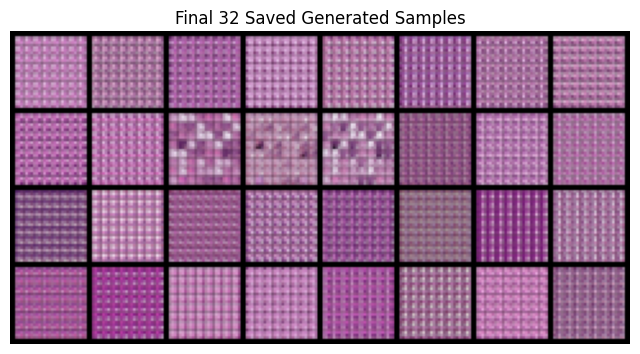

In [42]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch

# 1. Path to your saved generated images
folder_path = "./generated_samples"

# 2. Get list of image filenames (you can customize selection logic)
all_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.png') or f.endswith('.jpg')])
selected_files = all_files[-32:]  # Pick last 32 images

# 3. Define image transform to tensor
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

# 4. Load and transform images
images = []
for filename in selected_files:
    img_path = os.path.join(folder_path, filename)
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img)
    images.append(img_tensor)

# 5. Stack into a batch tensor
images_tensor = torch.stack(images)

# 6. Create a grid of 32 images
grid = vutils.make_grid(images_tensor, nrow=8, padding=2)

# 7. Plot and save
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Final 32 Saved Generated Samples")
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.savefig("final_saved_grid.png")
plt.show()


In [43]:
pip install torchsummary


Note: you may need to restart the kernel to use updated packages.


In [49]:
from torchsummary import summary

# Generator summary
summary(netG, input_size=(nz, 1, 1))

# Discriminator summary
summary(netD, input_size=(3, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]          12,288
             Tanh-11            [-1, 3, 32, 32]               0
Total params: 12,140,032
Trainable params: 12,140,032
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo